<a href="https://colab.research.google.com/github/dimzog/Machine-Learning/blob/master/Draft%20-%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the Libraries

In [130]:
import warnings
warnings.filterwarnings('ignore')

!pip install unidecode
import unidecode

import seaborn as sns
sns.set(style="darkgrid")

import numpy as np
import pandas as pd
from time import time

import re
from tqdm import tqdm
from collections import defaultdict

import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('ggplot')

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import random
import pickle
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Preprocessing

## Preprocess

* Read the files

* Drop recipes with 1 ingredient

* Convert all Capitals to Lowers

* Create Column separated_ingredients

In [139]:
train_df = pd.read_json("train.json",  dtype={"id": "int64", "cuisine": "str", "ingredients": "str"})
train_df = train_df[train_df.ingredients.str.len() > 1]


# Convert to lowercase

train_df["seperated_ingredients"] = train_df.ingredients.str.lower()


# Remove punctuation

reg = re.compile("[^\w\s\,]")
train_df.seperated_ingredients.replace(reg, "", inplace=True)

train_df.head()

,id,cuisine,ingredients,seperated_ingredients
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom...","romaine lettuce, black olives, grape tomatoes,..."
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma...","plain flour, ground pepper, salt, tomatoes, gr..."
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...","eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']","water, vegetable oil, wheat, salt"
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay...","black pepper, shallots, cornflour, cayenne pep..."


## Lemmatize

* Words with the same roots become the same

* Remove numbers with percentages (for example 1%)

* Remove words with less than 2 characters

* Lemmatize

In [140]:
lemmatizer = WordNetLemmatizer()

# Tokenize and then lemmatize every word in ingredients

train_df["seperated_ingredients"] = train_df.seperated_ingredients.apply(
                  lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))


# Remove annoying whitespace added before and after ','

reg = re.compile(" , ")
train_df.seperated_ingredients.replace(reg, ",", inplace=True)

train_df.head()

,id,cuisine,ingredients,seperated_ingredients
0,10259,greek,"['romaine lettuce', 'black olives', 'grape tom...","romaine lettuce,black olive,grape tomato,garli..."
1,25693,southern_us,"['plain flour', 'ground pepper', 'salt', 'toma...","plain flour,ground pepper,salt,tomato,ground b..."
2,20130,filipino,"['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...","egg,pepper,salt,mayonaise,cooking oil,green ch..."
3,22213,indian,"['water', 'vegetable oil', 'wheat', 'salt']","water,vegetable oil,wheat,salt"
4,13162,indian,"['black pepper', 'shallots', 'cornflour', 'cay...","black pepper,shallot,cornflour,cayenne pepper,..."


## Examining Missing Values

In [141]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=["Total missing", "Percent missing"])
missing_train_data.head(20)

,Total missing,Percent missing
seperated_ingredients,0,0.0
ingredients,0,0.0
cuisine,0,0.0
id,0,0.0


In [142]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 0 to 39773
Data columns (total 4 columns):
id                       39774 non-null int64
cuisine                  39774 non-null object
ingredients              39774 non-null object
seperated_ingredients    39774 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [81]:
train_df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

## Create Train and Test Data (Sparse Matrices)

* Vectorize train_df.separated_ingredients --> create X_train_vectorized

* Encode train_df.cuisine with values --> y_transformed = labels (0,..,19)

* Train & Test split (from X_train_vectorized and y_transformed) --> 80%, 20%

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

vect = TfidfVectorizer(binary=True).fit(train_df["seperated_ingredients"].values)
X_train_vectorized = vect.transform(train_df["seperated_ingredients"].values)
X_train_vectorized = X_train_vectorized.astype("float")

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)


X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , train_size=0.80, random_state = 0)

## Dictionary for y_train labels

In [6]:
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

# 2. Knowledge Representation

## Most Frequent Cuisines

### Create Colors

In [0]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ["#E86DA4"] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+"".join([random.choice("0123456789ABCDEF") for j in range(6)]))
    return colors

### 1ος Τρόπος

In [84]:
temp = train_df["cuisine"].value_counts()
trace = go.Bar(y=temp.index[::-1],x=(temp / temp.sum() * 100)[::-1],orientation = "h", marker=dict(color=random_colours(20))) # ,marker=color_theme
layout = go.Layout(title = "Top cuisine with recipe count (%)",xaxis=dict(title="Recipe count",tickfont=dict(size=14,)),
                   yaxis=dict(title='Cuisine',titlefont=dict(size=16),tickfont=dict(size=14)),margin=dict(l=200,), plot_bgcolor="rgb(255,255,255)")
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename="basic-bar")
temp = pd.DataFrame(temp)
temp.head()

,cuisine
italian,7838
mexican,6438
southern_us,4320
indian,3003
chinese,2673


### 2ος Τρόπος

In [9]:
labels = temp.index.tolist()
values = (temp["cuisine"]/temp["cuisine"].sum())*100

trace = go.Pie(labels=labels, values=values,hole = 0.4)

iplot([trace], filename="basic_pie_chart")

## Recipe Length Distribution by Cuisine

In [10]:
boxplotcolors = random_colours(20)
labels = [i for i in train_df.cuisine.value_counts().index][::-1]
data = []
for i in range(20):
    trace = go.Box(
    y=train_df[train_df['cuisine'] == labels[i]]["ingredients"].str.len(), name = labels[i],
    marker =  dict(color = boxplotcolors[i]))
    data.append(trace)

layout = go.Layout(title = "Recipe Length Distribution by cuisine", plot_bgcolor="rgb(255,255,255)")

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Box Plot Styling Outliers")

## Most Frequent Ingredients in the Whole Dataset

[("'", 856405), (' ', 768053), ('e', 601136), (',', 389129), ('a', 377670), ('r', 375418), ('s', 347417), ('o', 336706), ('l', 298702), ('i', 293736), ('n', 254335), ('c', 242977), ('t', 223786), ('p', 189699), ('g', 156155), ('u', 141497), ('d', 140434), ('h', 137912), ('m', 105076), ('b', 87638)]


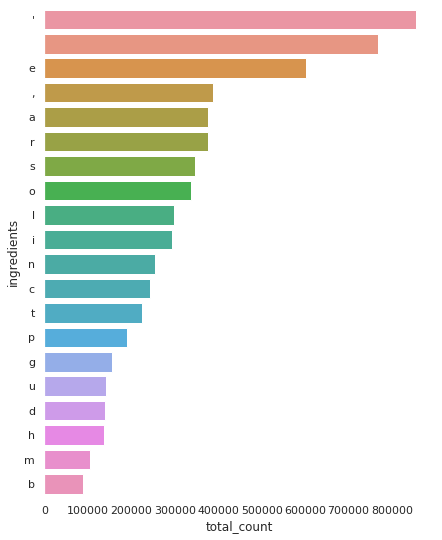

In [11]:
top = Counter([item for sublist in train_df['ingredients'] for item in sublist])
print(top.most_common(20))

temp = pd.DataFrame(top.most_common(20))
temp.columns = ["ingredients","total_count"]
plt.figure(figsize=(7,9))
sns.set(rc={"axes.facecolor":"white", "figure.facecolor":"white"})
sns.barplot(x="total_count",y="ingredients",data=temp)

## Examining Each Cuisine Seperately


In [0]:
def cuisine_dish(train, cuisine):
    temp1 = train[train['cuisine'] == cuisine]
    n=6714 # total ingredients in train data
    top = Counter([item for sublist in temp1.ingredients for item in sublist]).most_common(n)
    temp= pd.DataFrame(top)
    temp.columns = ["ingredient","total_count"]
    temp = temp.head(20)
    trace0 = go.Pie(labels=temp.ingredient[::-1], values=temp.total_count[::-1],hole = 0.4)
    data = [trace0]
    fig = go.Figure(data = data, layout= dict(title = "Famous Cuisine of '"+cuisine+"'"))
    iplot(fig,filename="basic_pie_chart")

a. Greek

In [13]:
cuisine_dish(train_df,"greek")

b. Indian

In [14]:
cuisine_dish(train_df,"indian")

## Most frequent biagrams 

In [0]:
train_df["for ngrams"]=train_df["seperated_ingredients"].str.replace(","," ")
def ingre_cusine(cuisine):
    frame=train_df[train_df["cuisine"]==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame["for ngrams"]))))
    return pd.DataFrame(Counter(common),index=["count"]).T.sort_values("count",ascending=False)[:15]

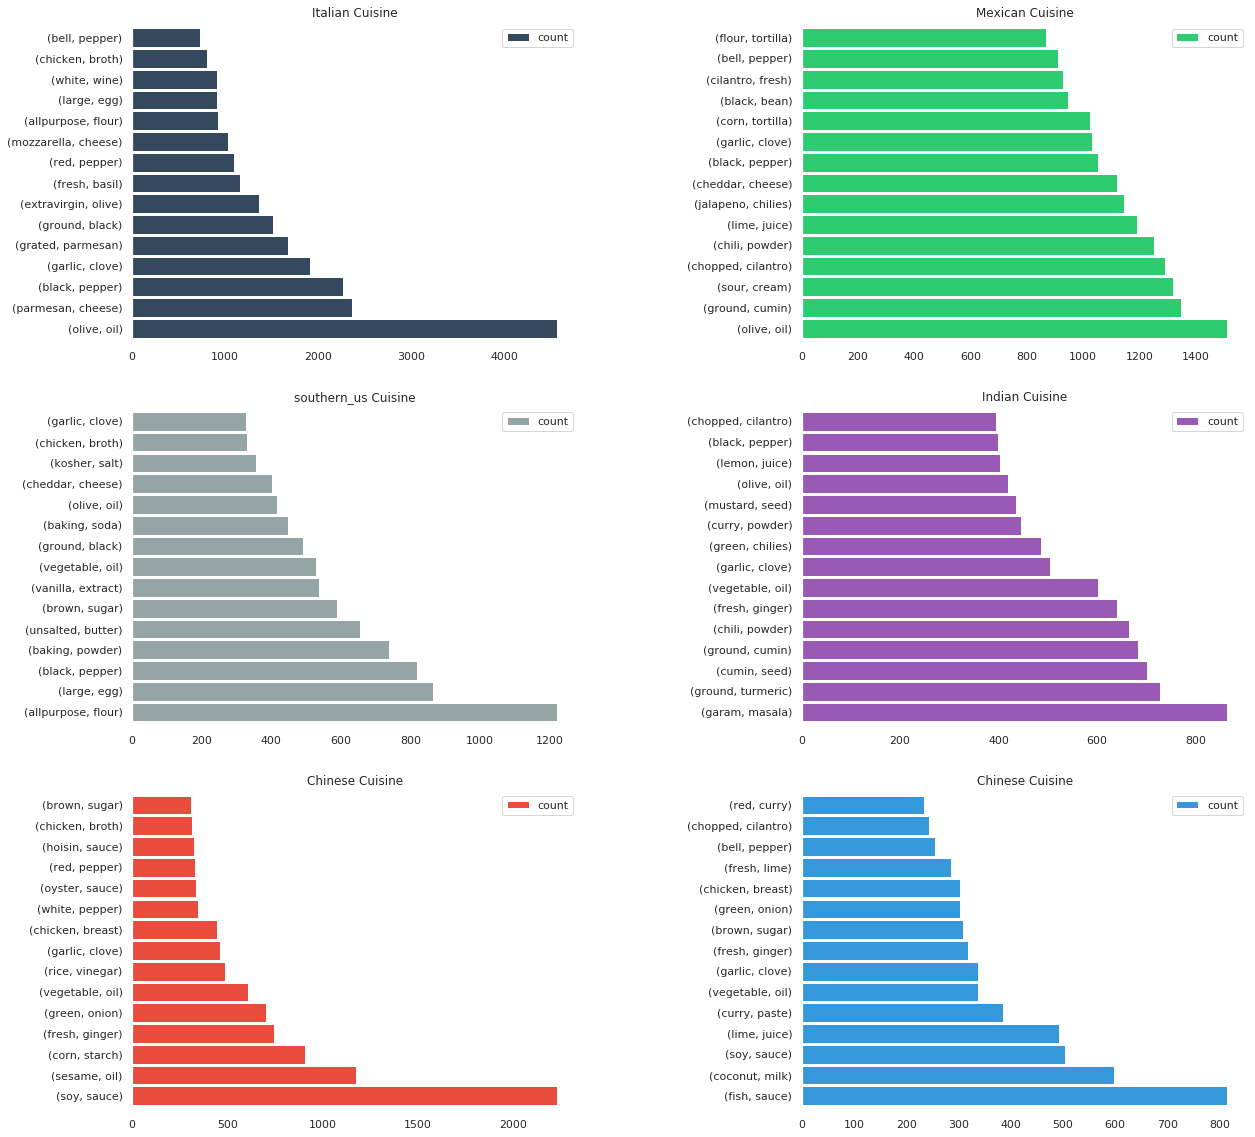

In [16]:
flatui = [ "#34495e", "#2ecc71", "#95a5a6","#9b59b6", "#e74c3c", "#3498db"]

f,ax=plt.subplots(3,2,figsize=(20,20))
ingre_cusine("italian").plot.barh(ax=ax[0,0],width=0.9,color= flatui[0])
ax[0,0].set_title("Italian Cuisine")
ingre_cusine("mexican").plot.barh(ax=ax[0,1],width=0.9,color = flatui[1] )
ax[0,1].set_title("Mexican Cuisine")
ingre_cusine("southern_us").plot.barh(ax=ax[1,0],width=0.9,color=flatui[2])
ax[1,0].set_title("southern_us Cuisine")
ingre_cusine("indian").plot.barh(ax=ax[1,1],width=0.9,color=flatui[3])
ax[1,1].set_title("Indian Cuisine")
ingre_cusine("chinese").plot.barh(ax=ax[2,0],width=0.9,color=flatui[4])
ax[2,0].set_title("Chinese Cuisine")
ingre_cusine("thai").plot.barh(ax=ax[2,1],width=0.9,color=flatui[5])
ax[2,1].set_title("Chinese Cuisine")
plt.subplots_adjust(wspace=0.5)

## Create Biagrams

In [0]:
import networkx as nx
def generate_ngrams(text, n):
    words = text.split(" ")
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]


def net_diagram(*cuisines):
    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[0]]["for ngrams"]:
            for ngram in generate_ngrams(title, 2):
                ngram = ",".join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ["count"]
    ngrams_mws_df["cusine"] = cuisines[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)

    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[1]]["for ngrams"]:
            for ngram in generate_ngrams(title, 2):
                ngram = ",".join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ["count"]
    ngrams_mws_df1["cusine"] = cuisines[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    cuisine1=ngrams_mws_df.sort_values("count",ascending=False)[:25]
    cuisine2=ngrams_mws_df1.sort_values("count",ascending=False)[:25]
    df_final=pd.concat([cuisine1,cuisine2])
    g = nx.from_pandas_edgelist(df_final,source="cusine",target='index')
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final["count"].values*8, cmap = cmap, node_color=colors, edge_color="grey", font_size=20, width=3)
    plt.title("Top 25 Bigrams for %s and %s" %(cuisines[0],cuisines[1]), fontsize=20)
    plt.gcf().set_size_inches(30,30)
    plt.show()
    plt.savefig("network.png")

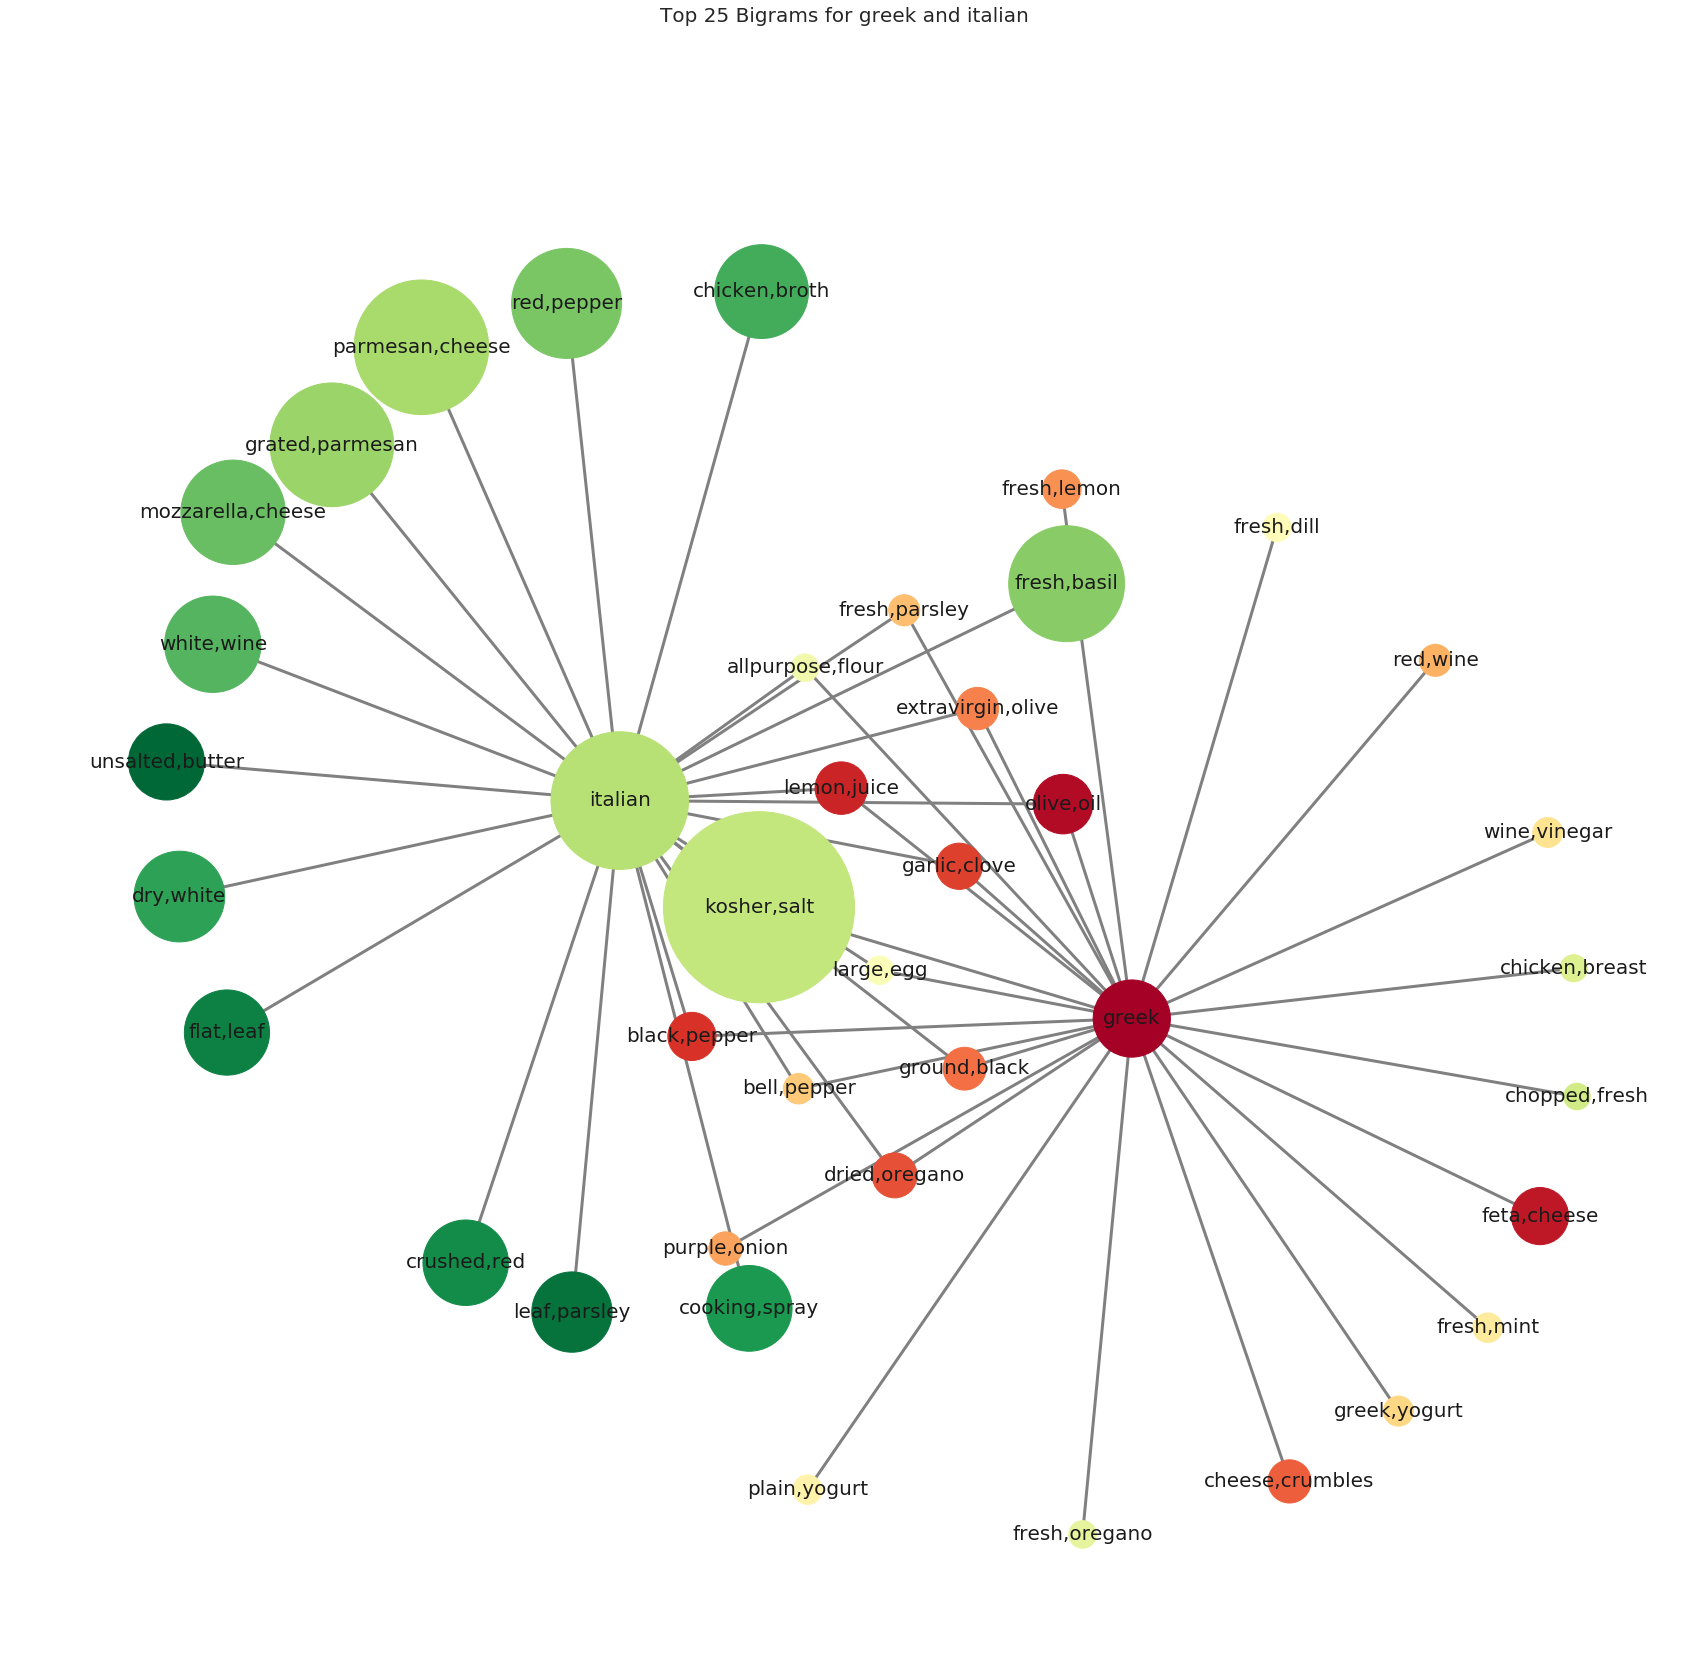

<Figure size 432x288 with 0 Axes>

In [18]:
net_diagram("greek","italian")

# Machine Learning with Sparse Data

## Logistic Regression

### Hyperparameter Tuning

In [103]:
pipe1 = Pipeline([('classifier' , LogisticRegression())])

param_grid1 = [
    {"classifier" : [LogisticRegression()],
     "classifier__penalty" : ["l2"],
    "classifier__solver" : ["newton-cg", "sag", "saga", "lbfgs"]},
   ]

# Create grid search object

clf1 = GridSearchCV(pipe, param_grid1 = param_grid1, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

clf1.fit(X_train, y_train)

clf1.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished


{'classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                    warm_start=False),
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

### Logistic Regression - Assessment

In [145]:
t = time.time()

# -------------------------- Logistic Regression Classifier -----------------------------------------

clf_logreg = LogisticRegression(penalty="l2", solver="newton-cg")
clf_logreg.fit(X_train, y_train)
y_pred_lr = clf_logreg.predict(X_test)

print("Logistic Regression Accuracy  (in %) : {0:0.2f}". format(accuracy_score(y_test, y_pred_lr)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Logistic Regression Accuracy  (in %) : 78.79

Χρόνος Εκτέλεσης Προγράμματος: 0.4 min


## Decision Tree

### Hyperparameter Tuning

In [131]:
# Create lists of parameter for Decision Tree Classifier

decisiontree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[("decisiontree", decisiontree)])

criterion = ["gini", "entropy"]
max_depth = [200, 250, 300, 350]

parameters = dict(decisiontree__criterion=criterion, decisiontree__max_depth=max_depth)

clf2 = GridSearchCV(pipe, parameters)

# Fit the grid search

clf2.fit(X_train, y_train)

print(clf2.best_params_)

{'decisiontree__criterion': 'gini', 'decisiontree__max_depth': 300}


### Assessment

In [135]:
t = time.time()

# ----------------------------- Decision Tree Classifier --------------------------------------------

clf_tree = DecisionTreeClassifier(max_depth=300, criterion="gini")
clf_tree.fit(X_train, y_train)                       
y_pred_dt = clf_tree.predict(X_test)                   

print("Decision Tree Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_dt)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Decision Tree Accuracy (in %) : 62.46

Χρόνος Εκτέλεσης Προγράμματος: 0.2 min


## K-Nearest Neighboor

### Selecting Best K-Neighbors


Χρόνος Εκτέλεσης Προγράμματος: 0.0 min


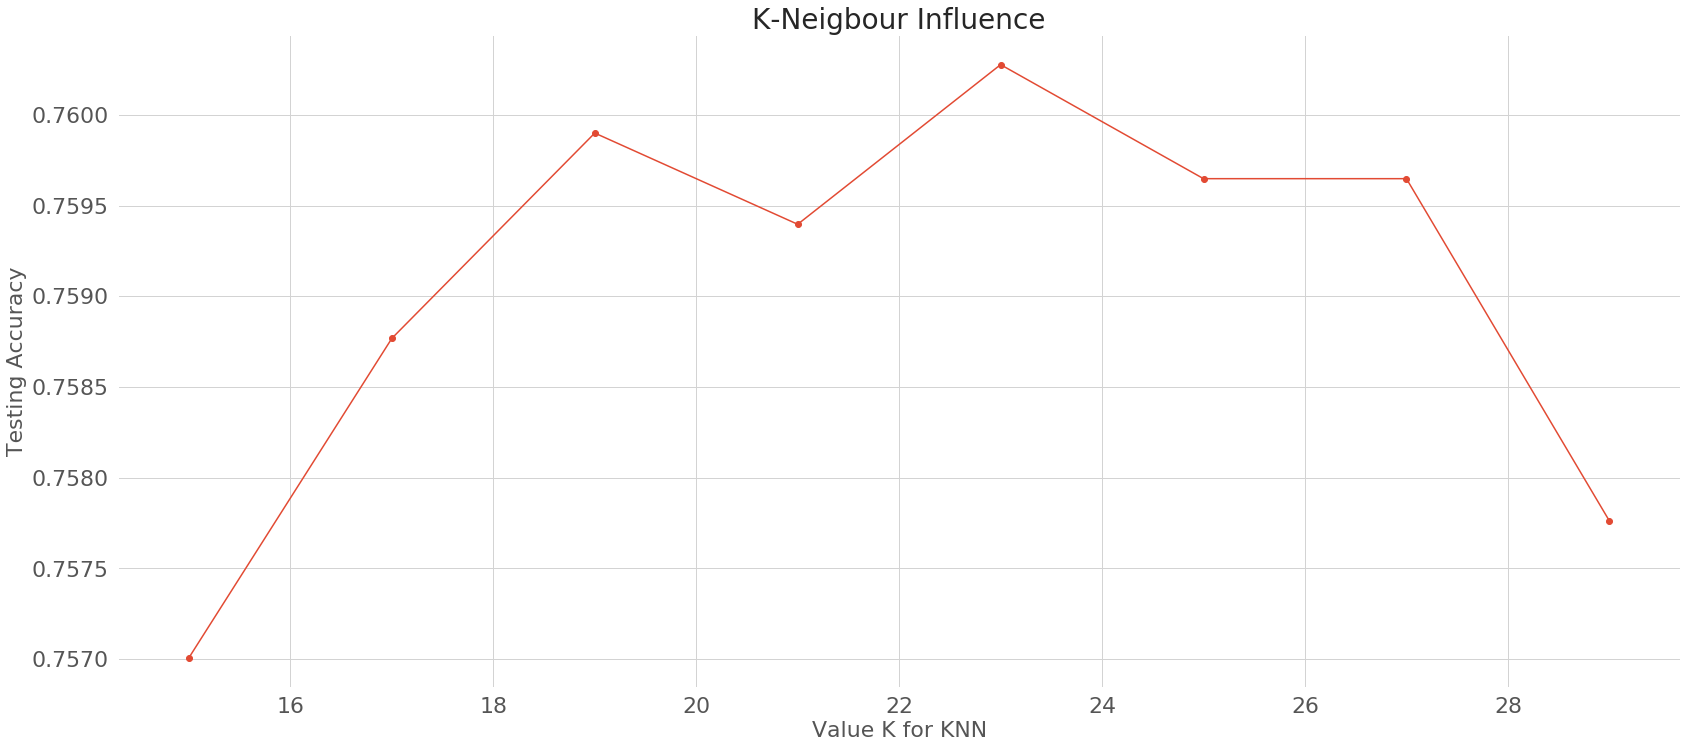

In [128]:
t = time.time()

--------------------------- K-Nearest Neighboor Classifier -------------------


k_range=range(15,31,2)
scores={}
scores_list=[]

for k in k_range:
    clf_knn=KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train,y_train)
    y_pred_knn=clf_knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test,y_pred_knn))
    

print("KNN Accuracy (in %) : {0:0.2f} " .format(round(max(scores_list)*100,2)))

fig=plt.subplots(figsize=(28,12))
plt.plot(k_range,scores_list,  marker="o")
plt.xlabel("Value K for KNN", size=22)
plt.ylabel("Testing Accuracy", size=22)
plt.title("K-Neigbour Influence", size=28)
plt.tick_params(axis="both", which="major", labelsize=22)
plt.grid(color="lightgrey")
plt.rcParams['axes.facecolor'] = 'white'

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

### Hyperparameter Tuning - KNN

In [115]:
dist = ["euclidean", "chebyshev", "manhattan"] # metric distance

clf3 = GridSearchCV(KNeighborsClassifier(), dict(n_neighbors=[23], metric=dist), cv=5, scoring='f1_macro', n_jobs=-1)

clf3.fit(X_train, y_train)

print(clf3.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'chebyshev', 'manhattan'],
                         'n_neighbors': [21]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0)

In [116]:
print(clf3.best_params_)

{'metric': 'euclidean', 'n_neighbors': 21}


### Save the best performance of KNN

In [118]:
t = time.time()

# --------------------------- K-Nearest Neighboor Classifier -------------------

clf_knn=KNeighborsClassifier(n_neighbors=23, metric="euclidean")
clf_knn.fit(X_train,y_train)
y_pred_knn=clf_knn.predict(X_test)

print("K-Nearest Neighbor Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_knn)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

K-Nearest Neighbor Accuracy (in %) : 75.94

Χρόνος Εκτέλεσης Προγράμματος: 0.2 min


## Random Forest

### Hyperparameter Tuning - Random Forest

In [0]:
forest = RandomForestClassifier(random_state = 1)

param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [300],
    'criterion' :['gini', 'entropy']
}

clf4 = GridSearchCV(forest, param_grid=param_grid, cv = 5, n_jobs = -1)

clf4.fit(X_train, y_train)

clf4.best_params_

### Random Forest Assessment 

In [24]:
t = time.time()

#  --------------------- Random Forest Classifier -------------------------------

rlf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
rlf.fit(X_train, y_train)
y_pred_rlf = rlf.predict(X_test)

print("Random Forest Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_rlf)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Random Forest Accuracy (in %) : 74.62

Χρόνος Εκτέλεσης Προγράμματος: 1.0 min


## Boosting Classifier

In [0]:
# -------------------------  GradientBoosting Classifier -----------------------------

from sklearn.ensemble import GradientBoostingClassifier

t = time.time()

grbo = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, 
                                  random_state=0, loss='deviance').fit(X_train, y_train)

grbo.fit(X_train, y_train)
y_pred_grbo=grbo.predict(X_test)

print("Adaboost Classifier Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_grbo)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))


# ------------------------------------------------------------------------------


# # -------------------------  Adaboost Classifier -----------------------------

# from sklearn.ensemble import AdaBoostClassifier

# t = time.time()

# clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
# clf_ada.fit(X_train, y_train)
# y_pred_ada=clf_ada.predict(X_test)

# print("Adaboost Classifier Accuracy (in %) : {0:0.2f}" .format(accuracy_score(y_test, y_pred_ada)*100))

# elapsed = time.time() - t
# print()
# print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

## Multinomial Naive Bayes


In [25]:
t = time.time()

#  ------------------- Multinomial Naive Bayes Classifier ----------------------

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred_mnb = mnb.predict(X_test)

print("Multinomial Naive Bayes Accuracy  (in %) : {0:0.2f}". format(accuracy_score(y_test,y_pred_mnb)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Multinomial Naive Bayes Accuracy  (in %) : 67.97

Χρόνος Εκτέλεσης Προγράμματος: 0.0 min


## Kernel SVM (RBF)

In [26]:
t = time.time()

#  ------------------- Kernel SVM (RBF) Classifier -----------------

svclassifier = SVC(kernel="rbf")
svclassifier.fit(X_train, y_train)
y_pred_svm = svclassifier.predict(X_test)

print(classification_report(y_test,y_pred_svm))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

              precision    recall  f1-score   support

           0       0.91      0.56      0.69       107
           1       0.72      0.49      0.58       166
           2       0.77      0.72      0.74       270
           3       0.81      0.89      0.84       561
           4       0.78      0.61      0.69       140
           5       0.63      0.68      0.66       523
           6       0.85      0.69      0.76       246
           7       0.89      0.95      0.91       637
           8       0.75      0.52      0.61       121
           9       0.79      0.91      0.85      1551
          10       0.92      0.66      0.77       122
          11       0.87      0.67      0.76       275
          12       0.86      0.74      0.80       145
          13       0.91      0.92      0.92      1317
          14       0.86      0.77      0.81       161
          15       0.83      0.48      0.61        92
          16       0.71      0.82      0.76       852
          17       0.80    

## Precision, Recall and F1 score 

In [36]:
print("Logistic Regression metrics:", precision_recall_fscore_support(y_test,y_pred_lr, average="macro")[0:3])
print("\nDecision Tree metrics:",precision_recall_fscore_support(y_test,y_pred_dt, average="macro")[0:3])
print("\nK-Nearest Neighbor metrics:",precision_recall_fscore_support(y_test,y_pred_knn, average="macro")[0:3])
print("\nRandom Forest metrics:",precision_recall_fscore_support(y_test,y_pred_rlf, average="macro")[0:3])
print("\nKernel SVM metrics:",precision_recall_fscore_support(y_test,y_pred_svm, average="macro")[0:3])

Logistic Regression metrics: (0.76726894330573, 0.6701927041660027, 0.7077827737423286)

Decision Tree metrics: (0.5211782962227058, 0.5084218149472124, 0.5130552193508437)

K-Nearest Neighbor metrics: (0.7568130710720881, 0.6296752326563191, 0.6752207892164606)

Random Forest metrics: (0.7908531736732083, 0.5802571644973367, 0.641806263532661)

Kernel SVM metrics: (0.8124930274505319, 0.6987068010697131, 0.7428292319041991)


## ROC Curves

## Create Function for Micro Average ROC Curves

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def roc(y_test, y_pred):

    n_classes=20
    y_test = label_binarize(y_test, classes=[i for i in range(n_classes)])
    y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()

    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return fpr["micro"], tpr["micro"], roc_auc["micro"]

## Plot ROC Curves for each method

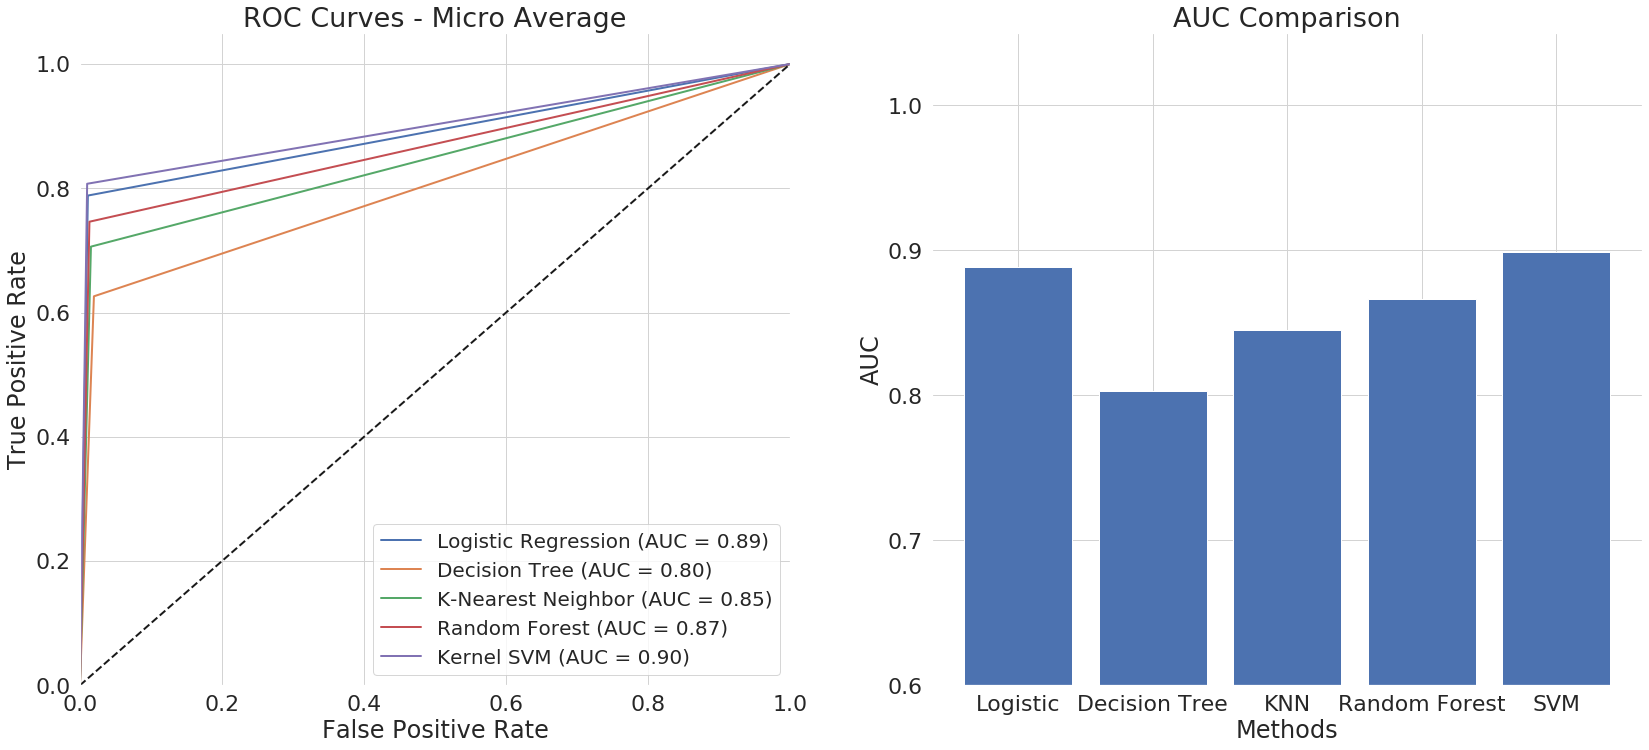

In [99]:
fpr_lr, tpr_lr, roc_auc_lr=roc(y_test, y_pred_lr)
fpr_dt, tpr_dt, roc_auc_dt=roc(y_test, y_pred_dt)
fpr_knn, tpr_knn, roc_auc_knn=roc(y_test, y_pred_knn)
fpr_rlf, tpr_rlf, roc_auc_rlf=roc(y_test, y_pred_rlf)
fpr_svm, tpr_svm, roc_auc_svm=roc(y_test, y_pred_svm)

# Plot all ROC curves

fig, (ax1,ax2)=plt.subplots(1,2, figsize=(28,12))
ax1.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = {0:0.2f})".format(roc_auc_lr), linewidth=2)
ax1.plot(fpr_dt, tpr_dt, label="Decision Tree (AUC = {0:0.2f})".format(roc_auc_dt), linewidth=2)
ax1.plot(fpr_knn, tpr_knn, label="K-Nearest Neighbor (AUC = {0:0.2f})".format(roc_auc_knn), linewidth=2)
ax1.plot(fpr_rlf, tpr_rlf, label="Random Forest (AUC = {0:0.2f})".format(roc_auc_rlf), linewidth=2)
ax1.plot(fpr_svm, tpr_svm, label="Kernel SVM (AUC = {0:0.2f})".format(roc_auc_svm), linewidth=2)
# 
ax1.plot([0, 1], [0, 1], "k--", lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel("False Positive Rate", size=24)
ax1.set_ylabel("True Positive Rate", size=24)
ax1.set_title("ROC Curves - Micro Average", size=27)
ax1.legend(loc="lower right", prop={"size": 20})
ax1.tick_params(axis="both", which="major", labelsize=22)
ax1.grid(color="lightgrey")

AUC=[roc_auc_lr, roc_auc_dt, roc_auc_knn, roc_auc_rlf, roc_auc_svm]    
bars = ["Logistic", "Decision Tree", "KNN", "Random Forest", "SVM"] 
y_pos = np.arange(len(bars))
 
# Create bars

ax2.bar(bars, AUC)
ax2.set_ylim([0.6, 1.05])
ax2.set_xlabel("Methods", size=24)
ax2.set_ylabel("AUC", size=24)
ax2.set_title("AUC Comparison", size=27)
ax2.tick_params(axis="both", which="major", labelsize=22)
ax2.grid(color="lightgrey")

# Show graphic

plt.show()
plt.rcParams['axes.facecolor'] = 'white'



In [96]:
index

0

## Voting Classifier

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

t = time.time()

vot=VotingClassifier(estimators=[("Logistic",clf_logreg),("SVM",CalibratedClassifierCV(svclassifier)),  
                        ("KNN",KNeighborsClassifier(n_neighbors=25)) ], voting="soft", weights=[3,15,2])

vot.fit(X_train,y_train)
y_pred_vot=vot.predict(X_test)

print("Soft VotingClassifier Accuracy : {in %}", round(accuracy_score(y_test, y_pred_vot)*100,2))


elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

# Dimensionality Reduction

## Estimate Covariance Matrix

In [146]:
covariance_matrix=np.cov(X_train.todense().transpose())

print("Διάσταση πίνακα συνδιασπορών :", np.shape(covariance_matrix))

U, s, V = np.linalg.svd(covariance_matrix)

x=range(1,len(s)+1)
y=np.cumsum(s)

Διάσταση πίνακα συνδιασπορών : (2845, 2845)


## Impact of Principal Components

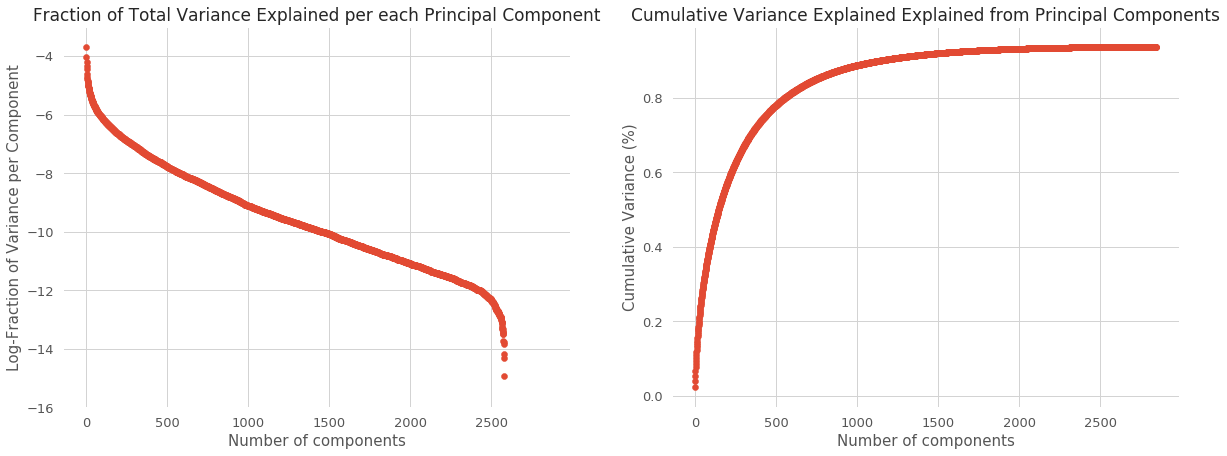

In [153]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7))

ax1.scatter(np.array(range(1,len(s)+1)), np.log(s/np.sum(s)))
ax1.set_ylim(-16,-3)
ax1.set_ylabel("Log-Fraction of Variance per Component", size=15)
ax1.set_xlabel("Number of components", size=15)
ax1.set_title("Fraction of Total Variance Explained per each Principal Component", size=17)
ax1.tick_params(axis="both", which="major", labelsize=13)
ax1.grid(color='lightgrey')
plt.rcParams['axes.facecolor'] = 'white'

ax2.scatter(x,y)
ax2.set_xlabel("Number of components", size=15) 
ax2.set_ylabel("Cumulative Variance (%)", size=15) 
ax2.set_title("Cumulative Variance Explained Explained from Principal Components", size=17) 
ax2.tick_params(axis="both", which="major", labelsize=13)
# plt.rcParams["axes.facecolor"] = "white"
ax2.tick_params(axis="both", which="major", labelsize=13)

ax2.grid(color="lightgrey")
plt.rcParams['axes.facecolor'] = 'white'

## Save Predictions of Each Method for different Components

In [186]:
features=[250,500,750,1150]

var=[]
acc_lr, list_pred_lr = [], []
acc_dt, list_pred_dt = [], []
acc_knn,list_pred_knn = [], []
acc_rlf, list_pred_rlf = [], []
acc_svm, list_pred_svm = [], []

for i in features:
    
    pca= PCA(n_components=i)

    pca.fit(X_train.todense())

    # Προβολή των train και test δεδομένων στους αξονες

    X_train_pca=pca.transform(X_train.todense())
    X_test_pca=pca.transform(X_test.todense())
        
    var.append(sum(pca.explained_variance_ratio_)*100)
     
    
    # -------------------------- Logistic Regression Classifier -----------------------------------------

    clf_logreg.fit(X_train_pca, y_train)
    y_pred_lr_pca = clf_logreg.predict(X_test_pca)
    
    acc_lr.append(accuracy_score(y_test, y_pred_lr_pca)*100)
    list_pred_lr.append(y_pred_lr_pca)
    print("logistic")
    
    
    # ----------------------------- Decision Tree Classifier --------------------------------------------

    clf_tree.fit(X_train_pca, y_train)                       
    y_pred_dt_pca = clf_tree.predict(X_test_pca)                   

    acc_dt.append(accuracy_score(y_test, y_pred_dt_pca)*100)     
    list_pred_dt.append(y_pred_dt_pca)
    print("tree")
    
     # --------------------------- K-Nearest Neighboor Classifier -------------------

    clf_knn.fit(X_train_pca,y_train)
    y_pred_knn_pca=clf_knn.predict(X_test_pca)

    acc_knn.append(accuracy_score(y_test, y_pred_knn_pca))
    list_pred_knn.append(y_pred_knn_pca)
    print("k-NN")
    
    #  --------------------- Random Forest Classifier -------------------------------

    rlf.fit(X_train_pca, y_train)
    y_pred_rlf_pca = rlf.predict(X_test_pca)
    
    acc_rlf.append(accuracy_score(y_test, y_pred_rlf_pca))
    list_pred_rlf.append(y_pred_rlf_pca)
    print("forest")

    
with open("list_lr.txt", "wb") as fp_lr:   
    pickle.dump(list_pred_lr , fp_lr) 
    

with open("list_dt.txt", "wb") as fp_dt:  
    pickle.dump(list_pred_dt , fp_dt) 
    


with open("list_knn.txt", "wb") as fp_knn:   
    pickle.dump(list_pred_knn , fp_knn) 


with open("list_rlf.txt", "wb") as fp_rlf:  
    pickle.dump(list_pred_rlf , fp_rlf) 

logistic
tree
k-NN
forest
logistic
tree
k-NN
forest
logistic
tree
k-NN
forest
logistic
tree
k-NN
forest


## Load Predictions of Each Method for different Components

In [0]:
with open("list_lr.txt", "rb") as list_lr:  
    list_pred_lr = pickle.load(list_lr)

with open("list_knn.txt", "rb") as list_knn:   
    list_pred_knn = pickle.load(list_knn)
    
with open("list_dt.txt", "rb") as list_dt:   
    list_pred_dt = pickle.load(list_dt)
    
with open("list_rlf.txt", "rb") as list_rlf:   
    list_pred_rlf = pickle.load(list_rlf)

## Assessment of Each Method for different Components

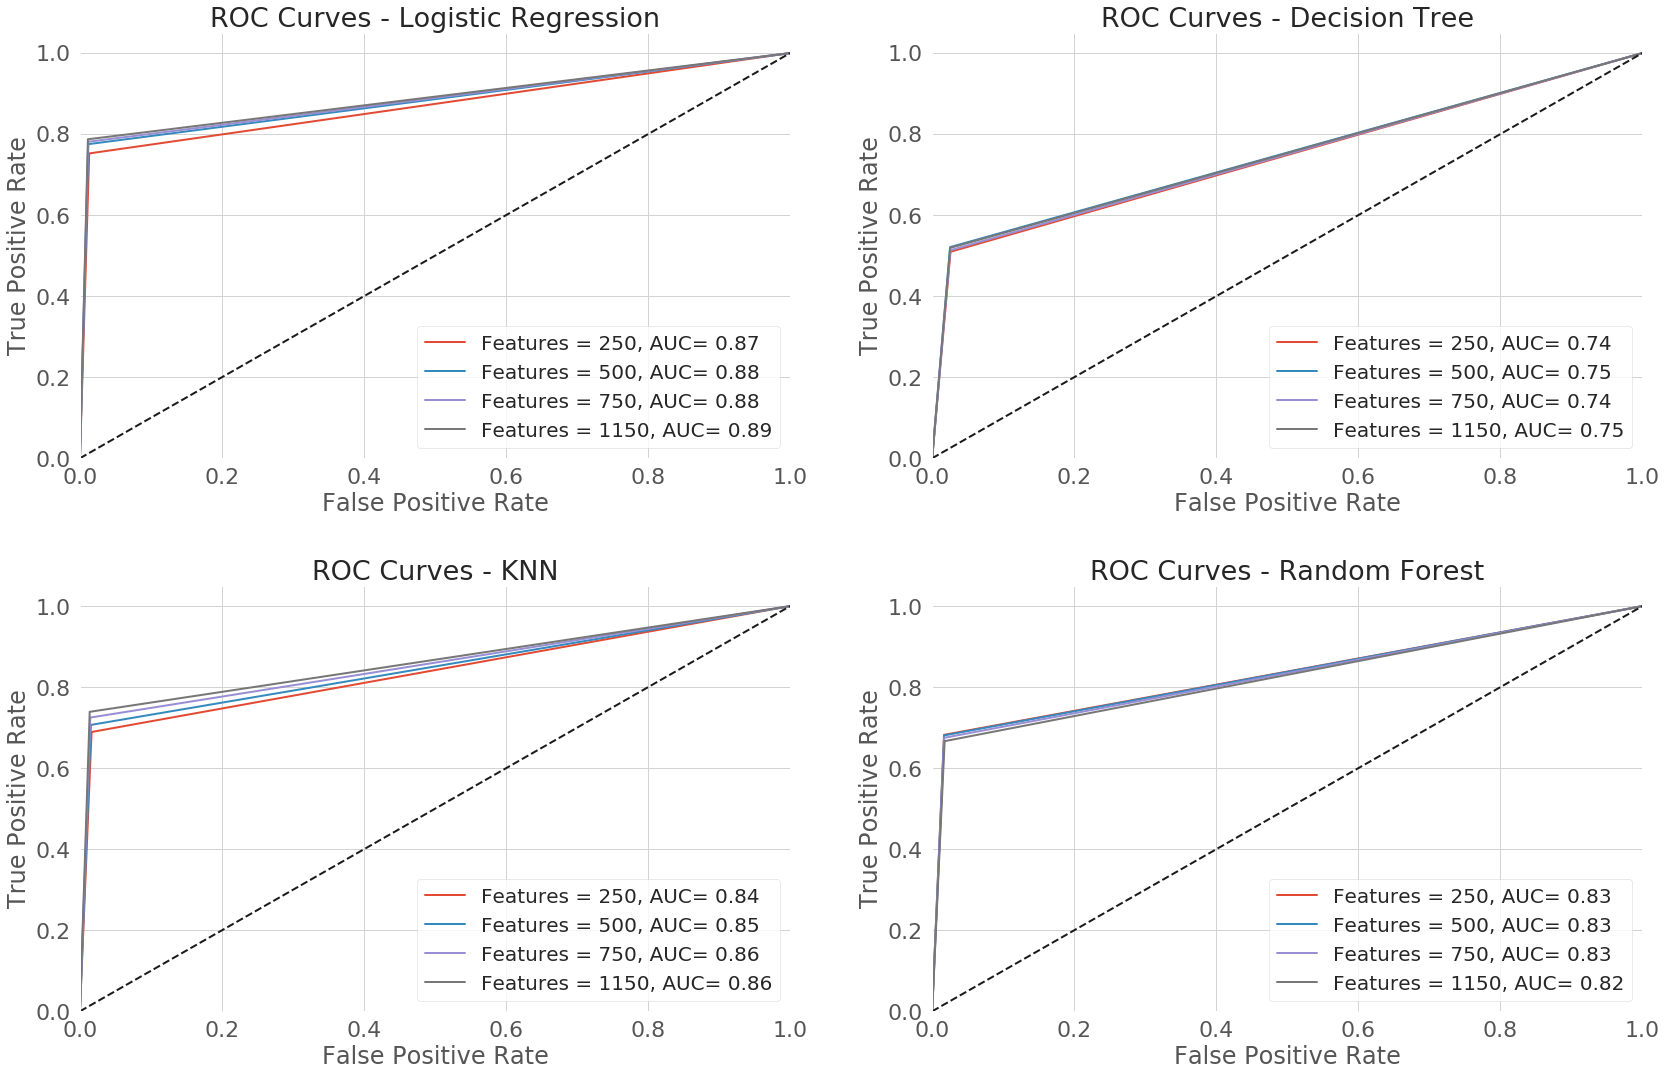

In [187]:
features=[250,500,750,1150]


# Plot all ROC curves

fig, ax =plt.subplots(2,2, figsize=(28,18))

for i in range(len(list_pred_lr)):
    
    ind1, ind2=0,0
    fpr_pca_lr, tpr_pca_lr, roc_auc_pca_lr=roc(y_test, list_pred_lr[i])
    ax[0,0].plot(fpr_pca_lr, tpr_pca_lr, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_lr), linewidth=2)


    fpr_pca_dt, tpr_pca_dt, roc_auc_pca_dt=roc(y_test, list_pred_dt[i])
    ax[0,1].plot(fpr_pca_dt, tpr_pca_dt, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_dt), linewidth=2)
    
    fpr_pca_knn, tpr_pca_knn, roc_auc_pca_knn=roc(y_test, list_pred_knn[i])
    ax[1,0].plot(fpr_pca_knn, tpr_pca_knn,label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_knn), linewidth=2)

    fpr_pca_rlf, tpr_pca_rlf, roc_auc_pca_rlf=roc(y_test, list_pred_rlf[i])
    ax[1,1].plot(fpr_pca_rlf, tpr_pca_rlf, label="Features = {}, AUC= {:.2f}".format(features[i], roc_auc_pca_rlf), linewidth=2)


methods = ["Logistic Regression", "Decision Tree", "KNN", "Random Forest"]

ind=0

for ax in ax.flat:

    ax.plot([0, 1], [0, 1], "k--", lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate", size=24)
    ax.set_ylabel("True Positive Rate", size=24)
    ax.legend(loc="lower right", prop={"size": 20})
    ax.set_title("ROC Curves - {}".format(methods[ind]), size=27)
    ax.tick_params(axis="both", which="major", labelsize=22)
    ax.grid(color="lightgrey")
    ind+=1

plt.subplots_adjust( hspace=0.3)

# Show graphic

plt.show()
